# OCEAN COLOR `TOKYO` EXAMPLE

記事：

In [2]:
import cartopy.crs as ccrs
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

auth = earthaccess.login(persist=True)

## Level 1B

In [3]:
tspan = ("2024-04-01", "2024-04-16")
bbox = (134.512,32.287, 141.576, 35.512)

results = earthaccess.search_data(
    short_name="PACE_OCI_L1B_SCI",
    temporal=tspan,
    bounding_box=bbox,
)

Granules found: 13


In [4]:
paths = earthaccess.open(results)

Opening 13 granules, approx size: 22.25 GB


QUEUEING TASKS | :   0%|          | 0/13 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/13 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/13 [00:00<?, ?it/s]

In [5]:
dataset = xr.open_dataset(paths[0])
dataset

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/33)
    title:                          PACE OCI Level-1B Data
    instrument:                     OCI
    product_name:                   PACE_OCI.20240411T033511.L1B.nc
    processing_version:             V1.0
    processing_level:               L1B
    cdm_data_type:                  swath
    ...                             ...
    geospatial_lon_min:             121.16643
    geospatial_lon_max:             151.74371
    geospatial_bounds_crs:          EPSG:4326
    history:                        2024-04-11T06:27:15Z: l1agen_oci OCI_temp...
    time_coverage_start:            2024-04-11T03:35:11.040
    time_coverage_end:              2024-04-11T03:40:10.923

In [6]:
with h5netcdf.File(paths[0]) as file:
    groups = list(file)
groups

['sensor_band_parameters',
 'scan_line_attributes',
 'geolocation_data',
 'navigation_data',
 'observation_data']

In [7]:
dataset = xr.open_dataset(paths[0], group="observation_data")
dataset

<xarray.Dataset> Size: 5GB
Dimensions:    (blue_bands: 119, number_of_scans: 1710, ccd_pixels: 1272,
                red_bands: 163, SWIR_bands: 9, SWIR_pixels: 1272)
Dimensions without coordinates: blue_bands, number_of_scans, ccd_pixels,
                                red_bands, SWIR_bands, SWIR_pixels
Data variables:
    rhot_blue  (blue_bands, number_of_scans, ccd_pixels) float32 1GB ...
    qual_blue  (blue_bands, number_of_scans, ccd_pixels) float32 1GB ...
    rhot_red   (red_bands, number_of_scans, ccd_pixels) float32 1GB ...
    qual_red   (red_bands, number_of_scans, ccd_pixels) float32 1GB ...
    rhot_SWIR  (SWIR_bands, number_of_scans, SWIR_pixels) float32 78MB ...
    qual_SWIR  (SWIR_bands, number_of_scans, SWIR_pixels) float32 78MB ...

In [8]:
dataset["rhot_blue"].sizes

Frozen({'blue_bands': 119, 'number_of_scans': 1710, 'ccd_pixels': 1272})

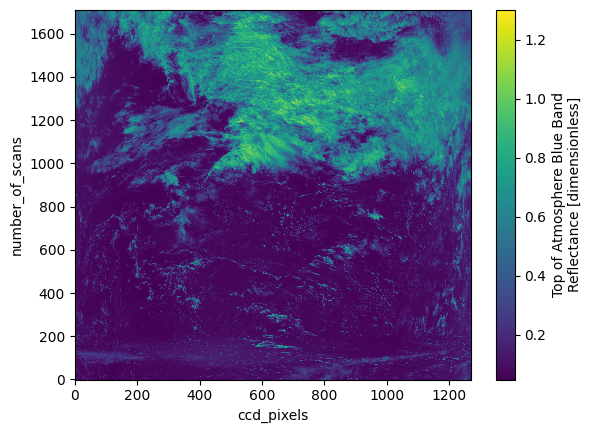

In [9]:
plot = dataset["rhot_blue"].sel({"blue_bands": 100}).plot()

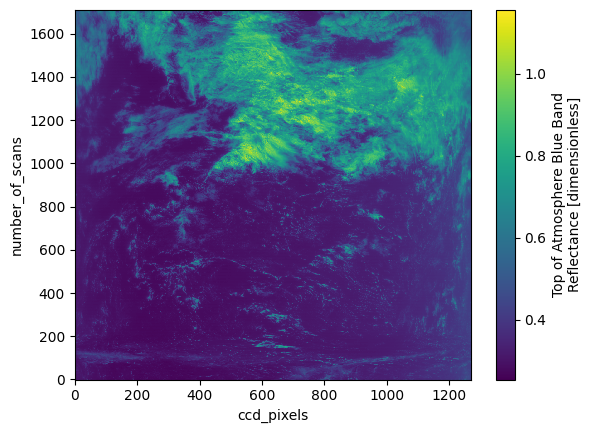

In [10]:
plot = dataset["rhot_blue"].sel({"blue_bands": 10}).plot()

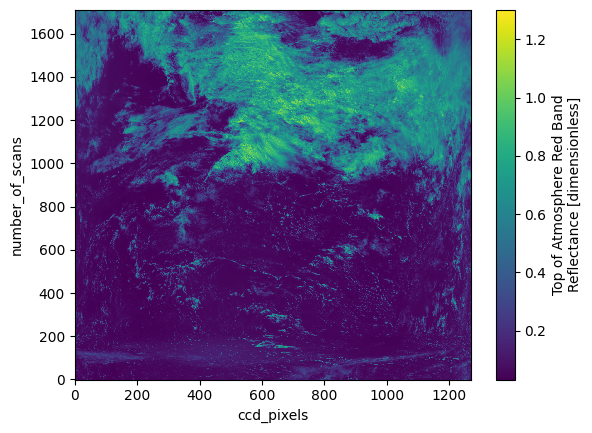

In [11]:
plot = dataset["rhot_red"].sel({"red_bands": 10}).plot()

## Level 2

In [12]:
clouds = (0, 50)

results = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP_NRT",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)

Granules found: 1


In [13]:
paths = earthaccess.open(results)

with h5netcdf.File(paths[0]) as file:
    groups = list(file)
groups

Opening 1 granules, approx size: 0.33 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['sensor_band_parameters',
 'scan_line_attributes',
 'geophysical_data',
 'navigation_data',
 'processing_control']

In [14]:
dataset = xr.open_dataset(paths[0], group="geophysical_data")
rrs = dataset["Rrs"]
rrs

<xarray.DataArray 'Rrs' (number_of_lines: 1710, pixels_per_line: 1272,
                         wavelength_3d: 184)> Size: 2GB
[400222080 values with dtype=float32]
Dimensions without coordinates: number_of_lines, pixels_per_line, wavelength_3d
Attributes:
    long_name:      Remote sensing reflectance
    units:          sr^-1
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    valid_min:      -30000
    valid_max:      25000

In [15]:
rrs.sizes

Frozen({'number_of_lines': 1710, 'pixels_per_line': 1272, 'wavelength_3d': 184})

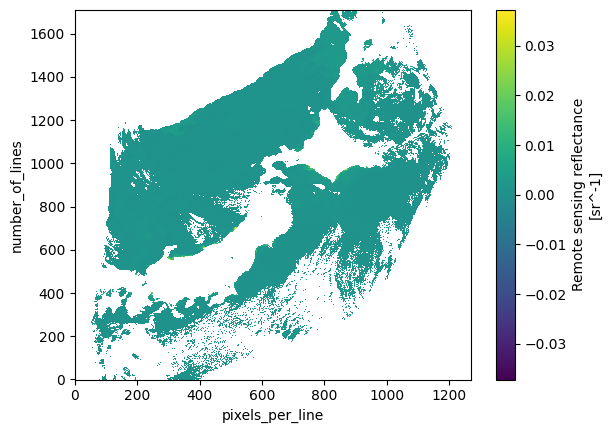

In [16]:
plot = rrs.sel({"wavelength_3d": 100}).plot(cmap="viridis")

In [17]:
dataset = xr.open_dataset(paths[0], group="navigation_data")
dataset = dataset.set_coords(("longitude", "latitude"))
dataset = dataset.rename({"pixel_control_points": "pixels_per_line"})
dataset = xr.merge((rrs, dataset.coords))
dataset

<xarray.Dataset> Size: 2GB
Dimensions:    (number_of_lines: 1710, pixels_per_line: 1272, wavelength_3d: 184)
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 9MB ...
    latitude   (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_lines, pixels_per_line, wavelength_3d
Data variables:
    Rrs        (number_of_lines, pixels_per_line, wavelength_3d) float32 2GB ...
Attributes:
    long_name:      Remote sensing reflectance
    units:          sr^-1
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    valid_min:      -30000
    valid_max:      25000

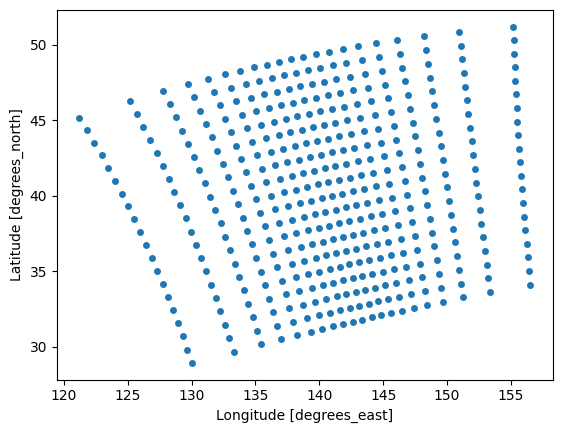

In [18]:
plot = dataset.sel(
    {
        "number_of_lines": slice(None, None, 1720 // 20),
        "pixels_per_line": slice(None, None, 1272 // 20),
    },
).plot.scatter(x="longitude", y="latitude")

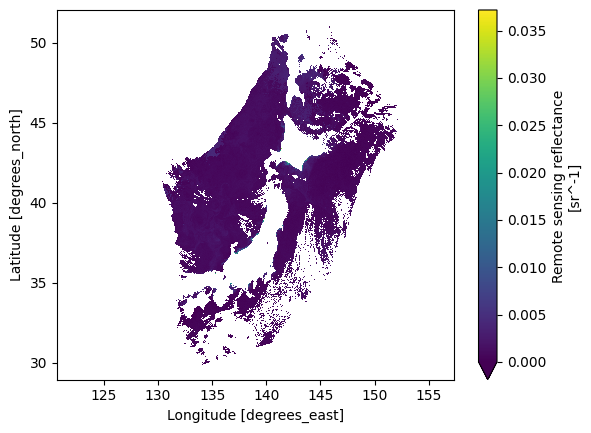

In [19]:
rrs = dataset["Rrs"].sel({"wavelength_3d": 100})
plot = rrs.plot(x="longitude", y="latitude", cmap="viridis", vmin=0)

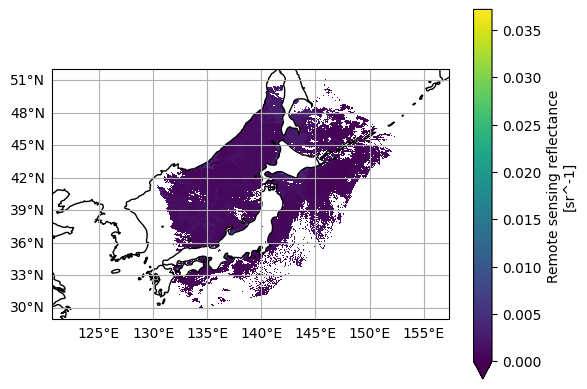

In [20]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = rrs.plot(x="longitude", y="latitude", cmap="viridis", vmin=0, ax=ax)

In [21]:
rrs_box = dataset["Rrs"].where(
    (
        (dataset["latitude"] > 36.52)
        & (dataset["latitude"] < 36.55)
        & (dataset["longitude"] < 142.46)
        & (dataset["longitude"] > 142.43)
    ),
    drop=True,
)
rrs_box.sizes

Frozen({'number_of_lines': 2, 'pixels_per_line': 3, 'wavelength_3d': 184})

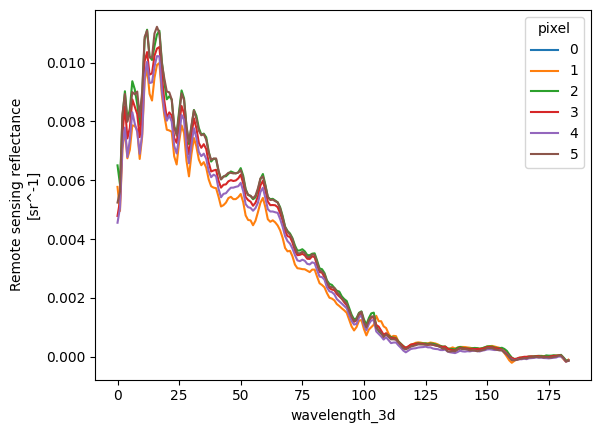

In [22]:
rrs_stack = rrs_box.stack(
    {"pixel": ["number_of_lines", "pixels_per_line"]}, create_index=False,
)
plot = rrs_stack.plot.line(hue="pixel")

## Level 3

In [23]:
tspan = ("2024-04-16", "2024-04-20")

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS_NRT",
    temporal=tspan,
    bounding_box=bbox,
)

Granules found: 30


In [24]:
paths = earthaccess.open(results)

dataset = xr.open_dataset(paths[0])
dataset

Opening 30 granules, approx size: 14.74 GB


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

<xarray.Dataset> Size: 262kB
Dimensions:  (lat: 180, lon: 360, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs_442  (lat, lon) float32 259kB ...
    palette  (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240401_20240430.L3m.MO.RRS....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/v1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         33885
    data_minimum:                      -0.0008579977
    data_maximum:                      0.07470851

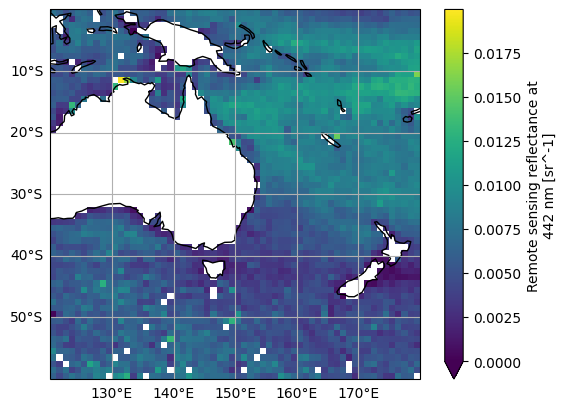

In [25]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})


rrs_442 = dataset["Rrs_442"].sel({"lat": slice(0, -60), "lon": slice(120, 180)})
plot = rrs_442.plot(cmap="viridis", vmin=0, ax=ax)

In [26]:
tspan = ("2024-04-12", "2024-04-24")

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL_NRT",
    temporal=tspan,
    granule_name="*.DAY.*.0p1deg.*",
)

Granules found: 13


In [27]:
paths = earthaccess.open(results)
dataset = xr.open_mfdataset(
    paths,
    combine="nested",
    concat_dim="date",
)
dataset

Opening 13 granules, approx size: 0.05 GB


QUEUEING TASKS | :   0%|          | 0/13 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/13 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/13 [00:00<?, ?it/s]

<xarray.Dataset> Size: 337MB
Dimensions:  (date: 13, lat: 1800, lon: 3600, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    chlor_a  (date, lat, lon) float32 337MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (date, rgb, eightbitcolor) uint8 10kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240412.L3m.DAY.CHL.V1_0_0.c...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CHL/v1
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         1081124
    data_minimum:                      0.0021566295
    data_maximum:                      94.466576

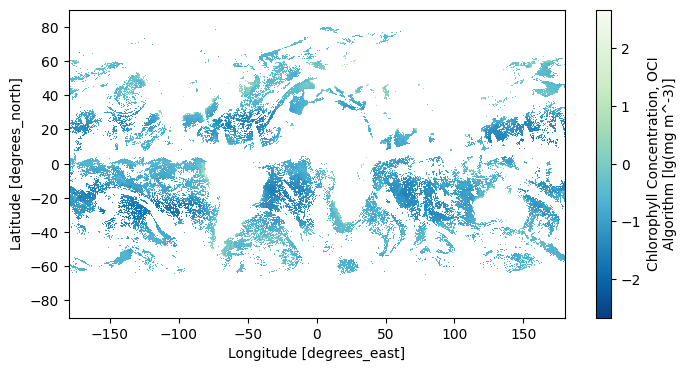

In [28]:
chla = np.log10(dataset["chlor_a"])
chla.attrs.update(
    {
        "units": f'lg({dataset["chlor_a"].attrs["units"]})',
    }
)
plot = chla.sel({"date": 0}).plot(aspect=2, size=4, cmap="GnBu_r")

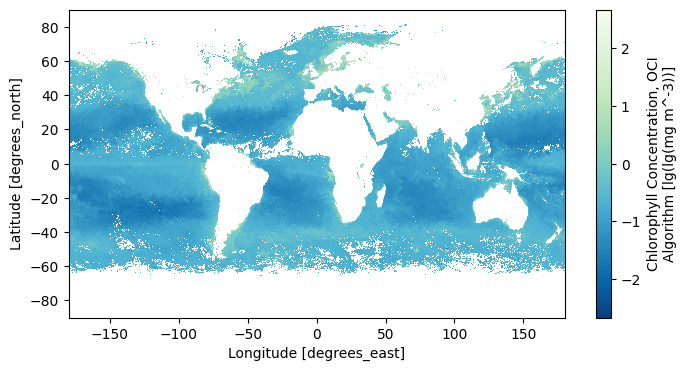

In [29]:
chla_avg = chla.mean("date")
chla_avg.attrs.update(
    {
        "long_name": chla.attrs["long_name"],
        "units": f'lg({chla.attrs["units"]})',
    }
)
plot = chla_avg.plot(aspect=2, size=4, cmap="GnBu_r")